# CALFEWS: California Food-Energy-Water System simulation model

This notebook will rerun the model in a simulation mode from WY 1996 - WY 2023. This model run and is not included in the manuscript, and was used to test the model validation for the Trinity Reservoir. 

Prior to running this notebook, follow the instructions in "README.md" to download the model and data, and install all Python dependencies.

In [1]:
%load_ext cython

In [2]:
%%cython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

C:\Users\amonkar\AppData\Local\anaconda3\envs\.venv_conda_calfews\lib\importlib\_bootstrap.py:219: RuntimeWarning: calfews_src.reservoir_cy.Reservoir size changed, may indicate binary incompatibility. Expected 936 from C header, got 960 from PyObject
  return f(*args, **kwds)
C:\Users\amonkar\AppData\Local\anaconda3\envs\.venv_conda_calfews\lib\importlib\_bootstrap.py:219: RuntimeWarning: calfews_src.delta_cy.Delta size changed, may indicate binary incompatibility. Expected 648 from C header, got 664 from PyObject
  return f(*args, **kwds)
C:\Users\amonkar\AppData\Local\anaconda3\envs\.venv_conda_calfews\lib\importlib\_bootstrap.py:219: RuntimeWarning: calfews_src.model_cy.Model size changed, may indicate binary incompatibility. Expected 1488 from C header, got 1496 from PyObject
  return f(*args, **kwds)


## Run validation 

First, make sure you do not already have output stored at ``results/Historical_validation_1996-2023`` or ``results/Historical_reconstruction_1906-2016``. If so, it needs to be moved or deleted, or it will cause an error.

Override parameter file with version in "runtime_params_validation.ini"

In [3]:
! copy runtime_params_updated.ini runtime_params.ini
#! copy runtime_params_validation.ini runtime_params.ini

        1 file(s) copied.


Run validation mode (1996-2023). This will take ~7-10 minutes. Note: you may need to change ``python`` to ``python3`` depending on your system setup.

In [4]:
results_validation = "results/Historical_validation_1996-2023"
! python -W ignore run_main_cy.py $results_validation 1 1

#######################################################
Begin initialization...
1995
2023
Initialization complete,  0:00:34.714497
Begin simulation,  0:00:34.714497
results/Historical_validation_1996-2023
Year  1.0 ,  0:00:48.768052
Year  2.0 ,  0:01:04.999883
Year  3.0 ,  0:01:20.122185
Year  4.0 ,  0:01:32.836587
Year  5.0 ,  0:01:44.050241
Year  6.0 ,  0:01:56.530050
Year  7.0 ,  0:02:07.524082
Year  8.0 ,  0:02:18.586418
Year  9.0 ,  0:02:33.379631
Year  10.0 ,  0:02:47.155774
Year  11.0 ,  0:03:01.012869
Year  12.0 ,  0:03:12.981531
Year  13.0 ,  0:03:23.297307
Year  14.0 ,  0:03:34.418333
Year  15.0 ,  0:03:45.944714
Year  16.0 ,  0:04:00.674892
Year  17.0 ,  0:04:12.685241
Year  18.0 ,  0:04:23.799555
Year  19.0 ,  0:04:33.982236
Year  20.0 ,  0:04:43.338972
Year  21.0 ,  0:04:54.034335
Year  22.0 ,  0:05:08.562616
Year  23.0 ,  0:05:20.486508
Year  24.0 ,  0:05:33.945924
Year  25.0 ,  0:05:45.799234
Year  26.0 ,  0:05:55.964046
Year  27.0 ,  0:06:06.590211
Year  28.0 ,  0:06:20

## Analyzing and visualizing model outputs
Results are stored in the HDF5 format, which is much more efficient for large files than using text files. 

### Retrieving data
However, in this tutorial we will show you how to interface directly with the model output in order to explore the data and create plots of your own.

In [5]:
# import libraries
import numpy as np
import pandas as pd
import h5py
import json
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import compress
import os
from datetime import datetime
from calfews_src import *
from calfews_src.visualizer import Visualizer

# Define the output folder path -- Added by Yash
output_folder = "results/Historical_validation_1996-2023/"

# results hdf5 file location from CALFEWS simulations
output_file = output_folder + 'results.hdf5'
fig_folder = output_folder + 'figs/'

# now load simulation output
datDaily = get_results_sensitivity_number_outside_model(output_file, '')

#Print the output data
datDaily.head()

,shasta_S,shasta_R,shasta_R_to_delta,shasta_available_storage,shasta_outflow_release,shasta_days_til_full,shasta_fci,shasta_tocs,shasta_Q,shasta_SNPK,...,kgr_FKC_flow,kgr_KWD_flow,kgr_TLB_flow,kgr_CNS_turnout,kgr_ALT_turnout,kgr_KRWA_turnout,kgr_FRS_turnout,kgr_FKC_turnout,kgr_KWD_turnout,kgr_TLB_turnout
1995-10-01,3129.000000,6.446281,6.446281,0.000000,6780.455943,999.99,100000.000000,4552.000000,0.000000,0.2,...,0.0,0.0,0.0,0.226822,0.150826,0.0,0.421546,0.0,0.0,0.0
1995-10-02,3122.281983,6.446281,6.446281,-8.360541,6768.842656,999.99,100239.999991,4530.333333,10.393388,0.2,...,0.0,0.0,0.0,0.225233,0.149913,0.0,0.418451,0.0,0.0,0.0
1995-10-03,3125.820496,6.446281,6.446281,-3.495331,6757.229369,999.99,99027.999985,4508.666667,7.537190,0.2,...,0.0,0.0,0.0,0.223644,0.149001,0.0,0.415355,0.0,0.0,0.0
1995-10-04,3126.707107,7.124480,7.124480,154.112516,6745.616082,999.99,97531.599980,4487.000000,6.852893,0.2,...,0.0,0.0,0.0,0.222055,0.148088,0.0,0.412259,0.0,0.0,0.0
1995-10-05,3125.959487,6.446281,6.446281,-16.164645,6734.002795,999.99,96900.019974,4465.333333,8.419835,0.2,...,0.0,0.0,0.0,0.220466,0.147175,0.0,0.409164,0.0,0.0,0.0


In [6]:
#Read the input data for comparision purposes
input_data = pd.read_csv("calfews_src/data/input/cord-sim_realtime.csv", index_col=0)
input_data.index = pd.to_datetime(input_data.index)

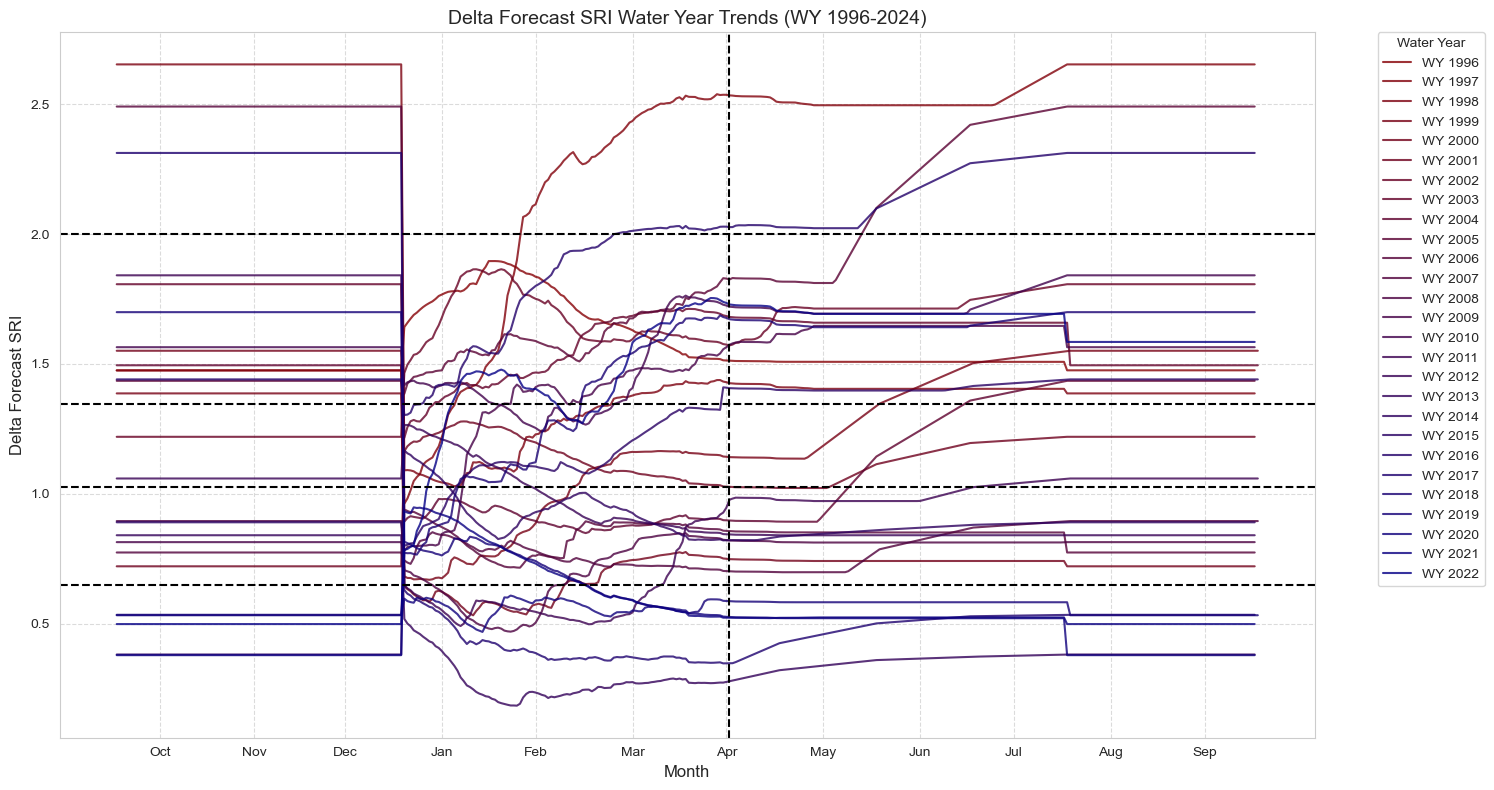

In [7]:
#Check 1 -- Forecasted Trinity River FnF flows.
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create figure and axis
plt.figure(figsize=(15, 8))

# Create a custom colormap that transitions from dark red to dark blue
colors = LinearSegmentedColormap.from_list('custom_red_blue', ['#8B0000', '#00008B'])

# Initialize empty lists to store lines for legend
lines = []
labels = []

# Function to calculate day of water year (Oct 1 = day 1)
def day_of_water_year(date):
    if date.month >= 10:
        return (date - pd.Timestamp(year=date.year, month=10, day=1)).days + 1
    else:
        return (date - pd.Timestamp(year=date.year-1, month=10, day=1)).days + 1

# Plot each water year's data
for year in range(1996, 2024):
    # Filter data for water year (Oct 1 of year to Sep 30 of year+1)
    mask = ((datDaily.index.month >= 10) & (datDaily.index.year == year)) | \
           ((datDaily.index.month < 10) & (datDaily.index.year == year + 1))
    water_year_data = datDaily['delta_forecastSTI'][mask]
    
    # Only plot if we have data for this water year
    if not water_year_data.empty:
        # Calculate days into water year for x-axis
        x_values = [day_of_water_year(date) for date in water_year_data.index]
        
        # Calculate color based on year position in range
        color = colors((year - 1995) / 28)
        
        # Plot the line
        line, = plt.plot(x_values, water_year_data.values, 
                        color=color, linewidth=1.5, alpha=0.8)
        
        # Store line and label for legend
        lines.append(line)
        labels.append(f'WY {year}')

#Customize the plots 
plt.axvline(x=197, color='black', linestyle='--')
plt.axhline(y=0.65, color='black', linestyle='--')
plt.axhline(y=1.025, color='black', linestyle='--')
plt.axhline(y=1.345, color='black', linestyle='--')
plt.axhline(y=2, color='black', linestyle='--')
        
# Customize the plot
plt.title('Delta Forecast SRI Water Year Trends (WY 1996-2024)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Delta Forecast SRI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(lines, labels, title='Water Year', bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)

# Set x-axis ticks for each month starting from October
month_positions = [15, 45, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 
               'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
plt.xticks(month_positions, month_labels)

# Adjust layout to prevent legend from being cut off
plt.tight_layout()

# Show the plot
plt.show()

## Trinity Storage 

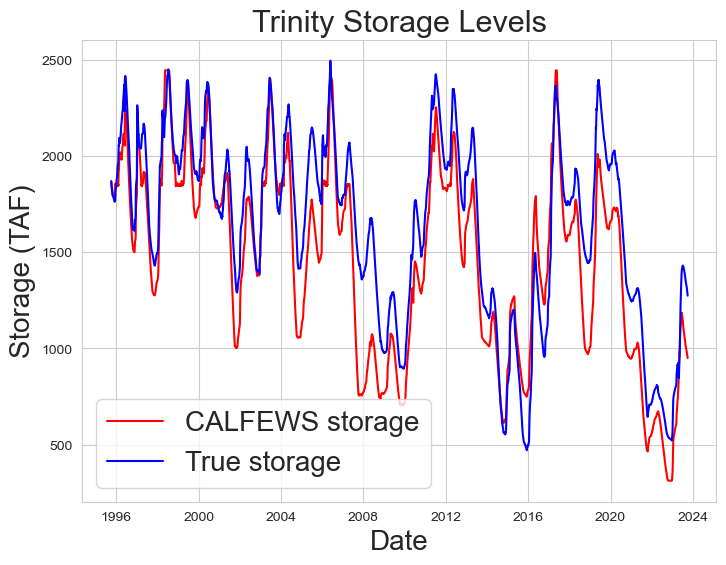

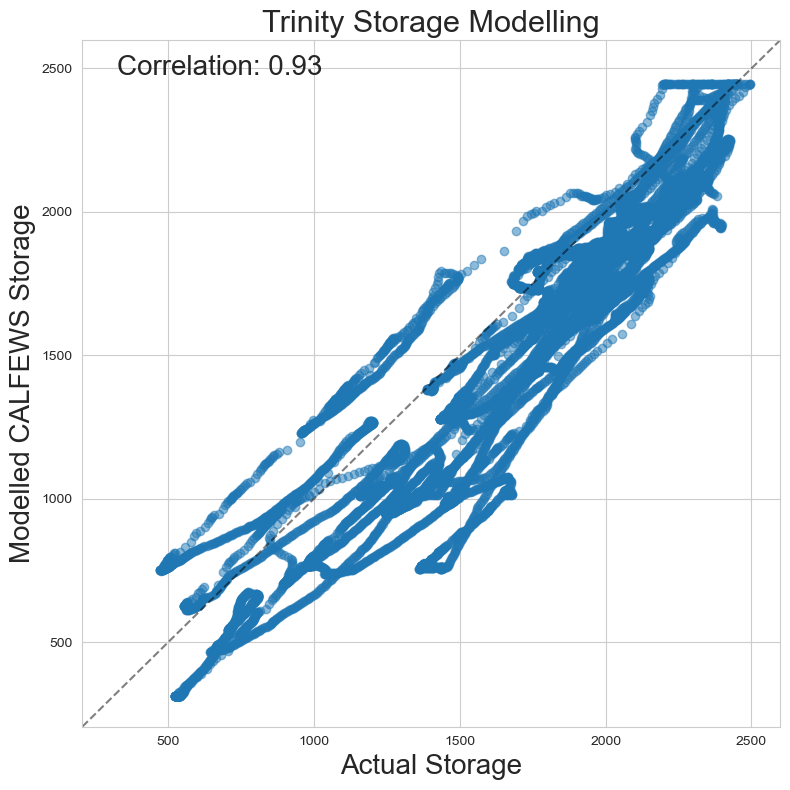

In [8]:
fig = plt.figure(figsize=(18,6))
ax = plt.subplot(122)
ax.plot(datDaily['trinity_S'], linestyle='-', color = 'red', label='CALFEWS storage')
ax.plot(input_data['TRT_storage']/1000, linestyle='-', color = 'blue', label='True storage')
ax.legend(fontsize = 20)
plt.title('Trinity Storage Levels', fontsize = 22)
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Storage (TAF)', fontsize = 20)


#-------------------------------------------------------------------------------#
#Scatter plot
# Compute correlation
correlation = (input_data['TRT_storage']/1000).corr(datDaily['trinity_S'])

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(input_data['TRT_storage']/1000, datDaily['trinity_S'], alpha=0.5)
xlim = plt.xlim()
ylim = plt.ylim()
min_val = min(xlim[0], ylim[0])
max_val = max(xlim[1], ylim[1])
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
plt.xlabel('Actual Storage', fontsize = 20)
plt.ylabel('Modelled CALFEWS Storage', fontsize = 20)
plt.title('Trinity Storage Modelling', fontsize = 22)
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize = 20)
plt.grid(True)
plt.tight_layout()
#plt.show()


## Trinity Releases

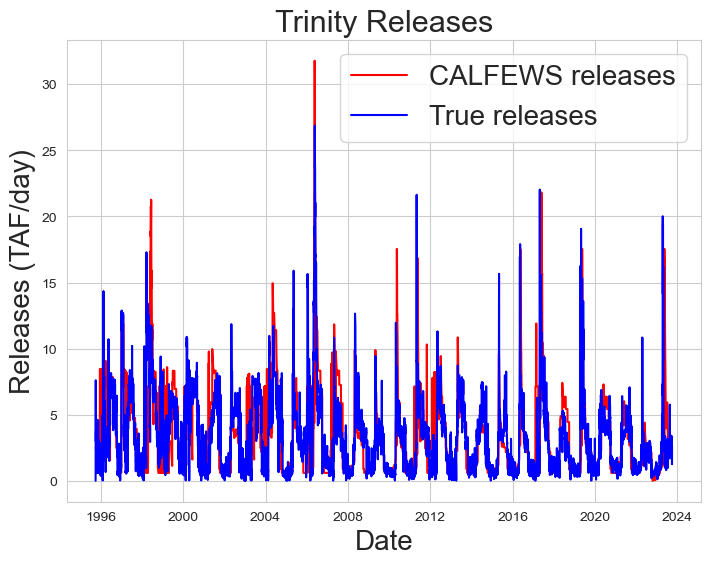

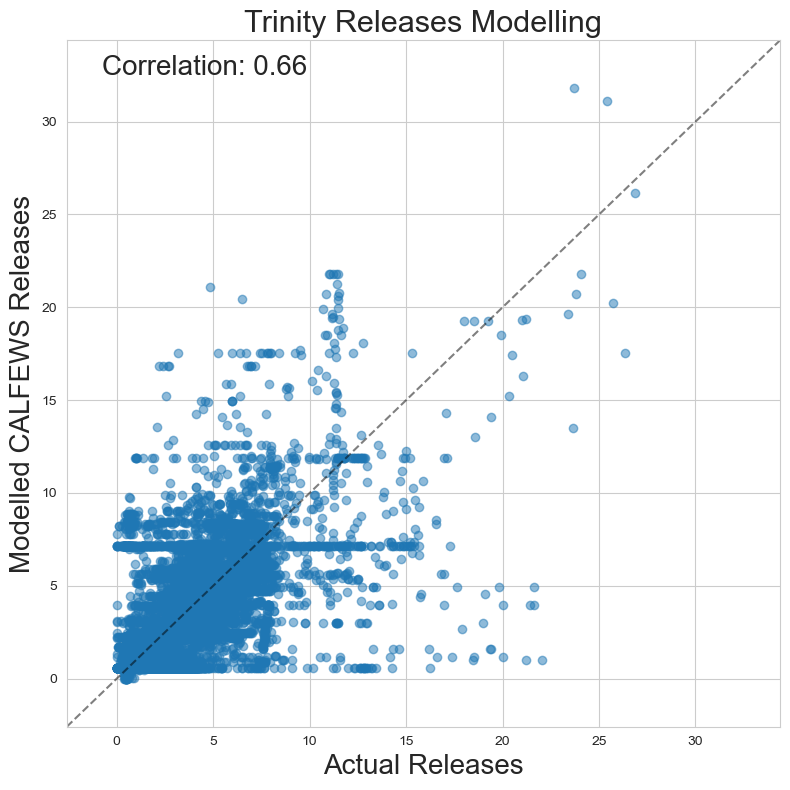

In [9]:
cfs_tafd = 2.29568411*10**-5 * 86400 / 1000

fig = plt.figure(figsize=(18,6))
ax = plt.subplot(122)
ax.plot(datDaily['trinity_R'], linestyle='-', color = 'red', label='CALFEWS releases')
ax.plot(input_data['TRT_otf']*cfs_tafd, linestyle='-', color = 'blue', label='True releases')
ax.legend(fontsize = 20)
plt.title('Trinity Releases', fontsize = 22)
ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Releases (TAF/day)', fontsize = 20)


#-------------------------------------------------------------------------------#
#Scatter plot
# Compute correlation
correlation = (input_data['TRT_otf']*cfs_tafd).corr(datDaily['trinity_R'])

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(input_data['TRT_otf']*cfs_tafd, datDaily['trinity_R'], alpha=0.5)
xlim = plt.xlim()
ylim = plt.ylim()
min_val = min(xlim[0], ylim[0])-1
max_val = max(xlim[1], ylim[1])+1
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
plt.xlabel('Actual Releases', fontsize = 20)
plt.ylabel('Modelled CALFEWS Releases', fontsize = 20)
plt.title('Trinity Releases Modelling', fontsize = 22)
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize = 20)
plt.grid(True)
plt.tight_layout()
plt.show()

## Monthly Releases 

In [10]:
# Resample to monthly
monthly_calfews_storage = datDaily['trinity_S'].resample('M').mean()
monthly_true_storage = (input_data['TRT_storage']/1000).resample('M').mean()
monthly_calfews_releases = datDaily['trinity_R'].resample('M').sum()
monthly_true_releases = (input_data['TRT_otf']*cfs_tafd).resample('M').sum()

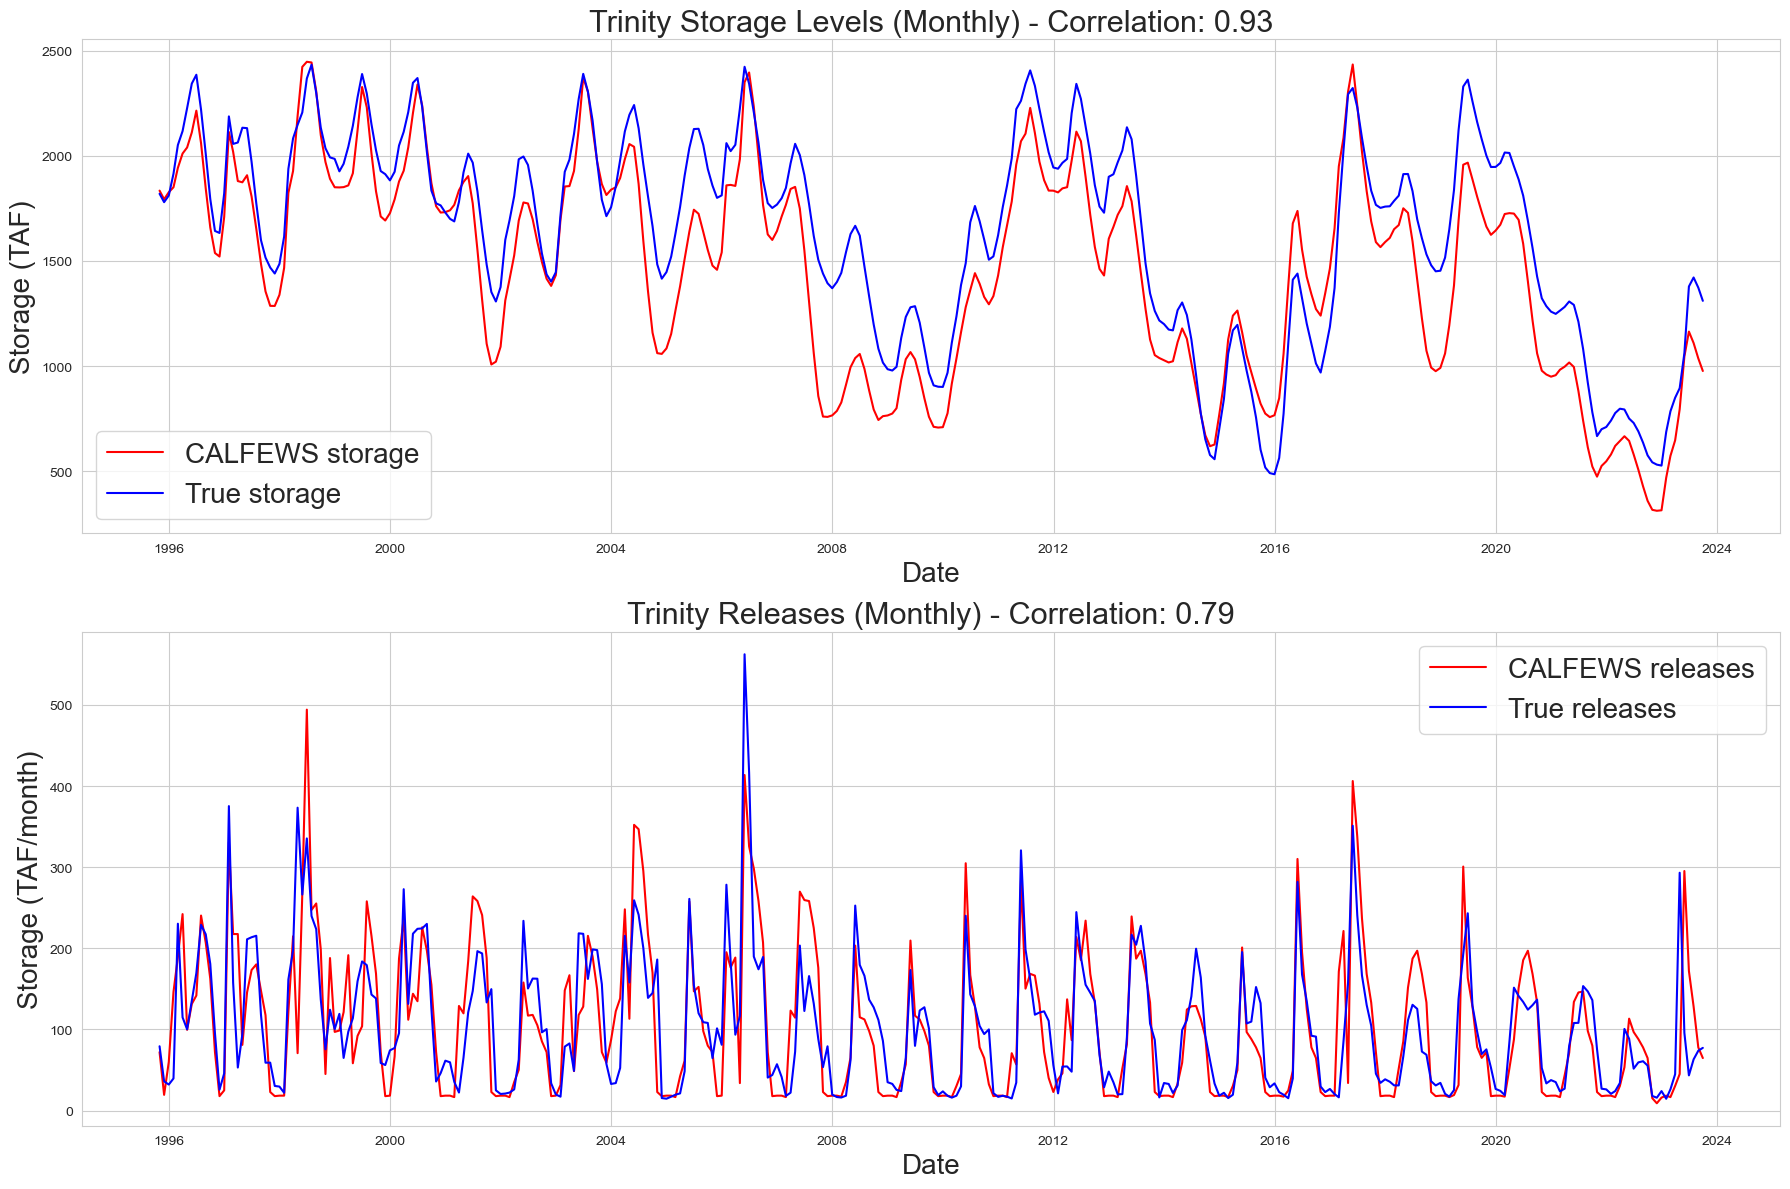

In [11]:
# Calculate correlations
storage_corr = np.corrcoef(monthly_calfews_storage, monthly_true_storage)[0,1]
release_corr = np.corrcoef(monthly_calfews_releases, monthly_true_releases)[0,1]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

# Storage plot
ax1.plot(monthly_calfews_storage, linestyle='-', color='red', label='CALFEWS storage')
ax1.plot(monthly_true_storage, linestyle='-', color='blue', label='True storage')
ax1.legend(fontsize=20)
ax1.set_title(f'Trinity Storage Levels (Monthly) - Correlation: {storage_corr:.2f}', fontsize=22)
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel('Storage (TAF)', fontsize=20)

# Release plot
ax2.plot(monthly_calfews_releases, linestyle='-', color='red', label='CALFEWS releases')
ax2.plot(monthly_true_releases, linestyle='-', color='blue', label='True releases')
ax2.legend(fontsize=20)
ax2.set_title(f'Trinity Releases (Monthly) - Correlation: {release_corr:.2f}', fontsize=22)
ax2.set_xlabel('Date', fontsize=20)
ax2.set_ylabel('Storage (TAF/month)', fontsize=20)

plt.tight_layout()
plt.show()

### Annual Distribution of Releases 

Visualize the Trinity flows by water year

In [12]:
def plot_water_year_releases(data, title='Water Year Releases', y_min = -5, y_limit=30):
    """
    Plot water year releases from a pandas Series with datetime index.
    
    Parameters:
    data (pd.Series): Time series data with datetime index
    title (str): Plot title
    y_limit (float): Y-axis limit
    """
    def day_of_water_year(date):
        if date.month >= 10:
            return (date - pd.Timestamp(year=date.year, month=10, day=1)).days + 1
        return (date - pd.Timestamp(year=date.year-1, month=10, day=1)).days + 1
    
    # Setup
    plt.figure(figsize=(15, 8))
    colors = LinearSegmentedColormap.from_list('custom_red_blue', ['#8B0000', '#00008B'])
    lines, labels = [], []
    
    # Calculate daily values and medians
    daily_values = {day: [] for day in range(1, 367)}
    start_year = data.index.year.min()
    end_year = data.index.year.max()
    
    for year in range(start_year, end_year + 1):
        mask = ((data.index.month >= 10) & (data.index.year == year)) | \
               ((data.index.month < 10) & (data.index.year == year + 1))
        water_year_data = data[mask]
        
        if not water_year_data.empty:
            for date, value in water_year_data.items():
                day = day_of_water_year(date)
                daily_values[day].append(value)
    
    daily_medians = {day: np.median(values) for day, values in daily_values.items() if values}
    
    # Plot each water year
    for year in range(start_year, end_year + 1):
        mask = ((data.index.month >= 10) & (data.index.year == year)) | \
               ((data.index.month < 10) & (data.index.year == year + 1))
        water_year_data = data[mask]
        
        if not water_year_data.empty:
            x_values = [day_of_water_year(date) for date in water_year_data.index]
            color = colors((year - start_year) / (end_year - start_year))
            line, = plt.plot(x_values, water_year_data.values, color=color, 
                           linewidth=1.5, alpha=0.8)
            lines.append(line)
            labels.append(f'WY {year}')
    
    # Plot median line
    median_line, = plt.plot(list(daily_medians.keys()), list(daily_medians.values()), 
                           'r-', linewidth=2.5, label='Median')
    lines.append(median_line)
    labels.append('Median')
    
    # Formatting
    plt.title(f'{title} Total = {data.sum()/1000:.2f} MAF', fontsize=18)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Releases (TAF)', fontsize=12)
    plt.ylim(y_min, y_limit)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(lines, labels, title='Water Year', bbox_to_anchor=(1.05, 1), 
              loc='upper left', borderaxespad=0.)
    
    month_positions = [15, 45, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]
    month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 
                   'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    plt.xticks(month_positions, month_labels)
    plt.tight_layout()
    
    #return plt.gcf()


# %%

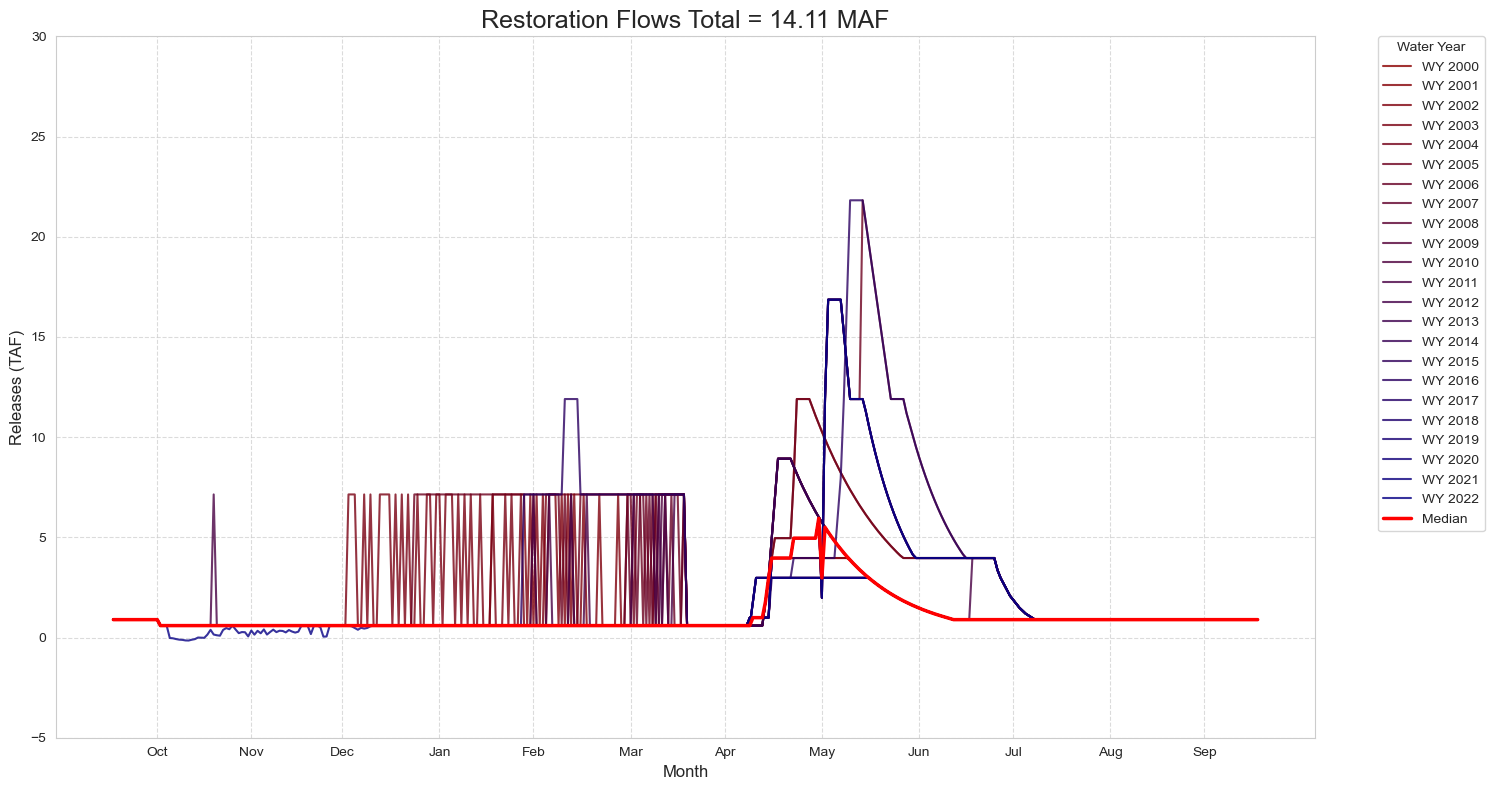

In [13]:
#Filter the dataset (to the post ROD 2000 period)
datDaily_subset = datDaily[datDaily.index < pd.Timestamp('2023-10-01')]
datDaily_subset = datDaily_subset[datDaily_subset.index > pd.Timestamp('2000-09-30')]

#Restoration Flows
plot_water_year_releases(datDaily_subset['trinity_restoration'], title='Restoration Flows')


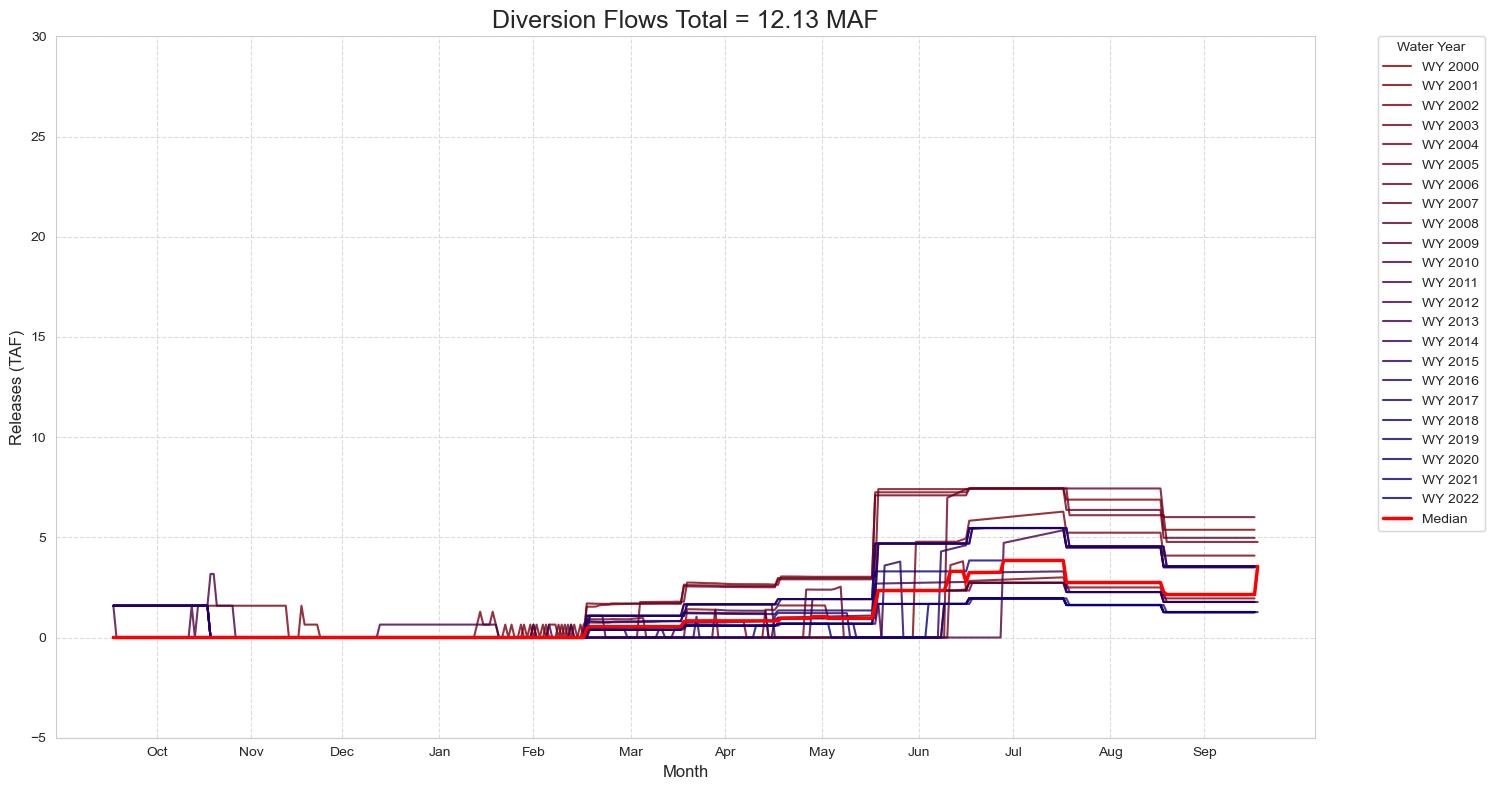

In [14]:
#CVP Diversion Flows
plot_water_year_releases(datDaily_subset['trinity_diversions'], title='Diversion Flows')


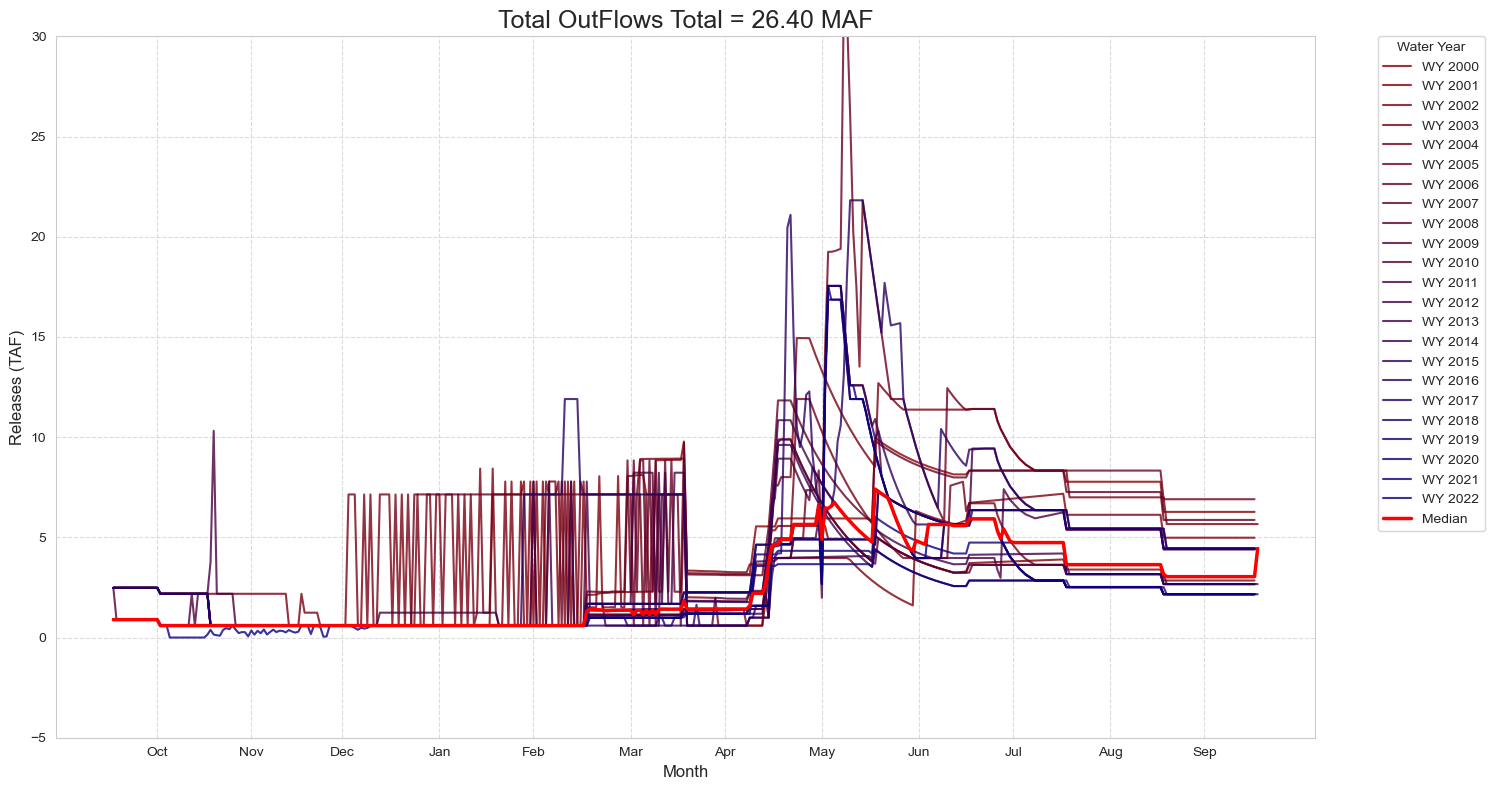

In [15]:
#Total Trinity Releases
plot_water_year_releases(datDaily_subset['trinity_R'], title='Total OutFlows')

###  Annual Distribution of Releases (at Trinity), Diversions and Restoration Flows (2001-2023)

In [16]:
def compare_series(series1: pd.Series, series2: pd.Series, start_date: str, end_date: str, 
                  series_name: str, figsize=(12, 5)):
    """
    Create a comparison visualization of two time series.
    
    Parameters:
    -----------
    series1 : pd.Series
        First time series with datetime index
    series2 : pd.Series
        Second time series with datetime index
    start_date : str
        Start date in format 'YYYY-MM-DD'
    end_date : str
        End date in format 'YYYY-MM-DD'
    series_name : str
        Name of the series (e.g., 'Releases', 'Diversions')
    figsize : tuple, optional
        Figure size, default is (12, 5)
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure containing both plots
    """
    
    # Convert dates to datetime if they're strings
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Filter data based on date range
    mask = (series1.index >= start_date) & (series1.index <= end_date)
    series1_filtered = series1[mask]
    series2_filtered = series2[mask]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Time series plot
    ax1.plot(series1_filtered.index, series1_filtered.values, 'r-o', label='CALFEWS',
            markersize=6, markerfacecolor='red', markeredgecolor='red')
    ax1.plot(series2_filtered.index, series2_filtered.values, 'b-o', label='Data',
             markersize=6, markerfacecolor='blue', markeredgecolor='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(series_name)
    ax1.legend()
    ax1.grid(True)
    ax1.set_title(f'{series_name}', fontsize = 16)
    
    # Scatter plot with 45-degree line
    # Find min and max values across both series for equal axes
    min_val = min(series1_filtered.min(), series2_filtered.min())
    max_val = max(series1_filtered.max(), series2_filtered.max())
    
    # Add some padding to the limits
    padding = (max_val - min_val) * 0.05
    min_val -= padding
    max_val += padding
    
    # Create scatter plot
    ax2.scatter(series1_filtered, series2_filtered, c='blue', alpha=0.6)
    
    # Add 45-degree line
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='45° line')
    
    # Set equal limits for both axes
    ax2.set_xlim(min_val, max_val)
    ax2.set_ylim(min_val, max_val)
    
    ax2.set_xlabel('CALFEWS')
    ax2.set_ylabel('Data')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title(f'{series_name}', fontsize = 16)
    
    # Make layout tight
    plt.tight_layout()
    
    #return fig

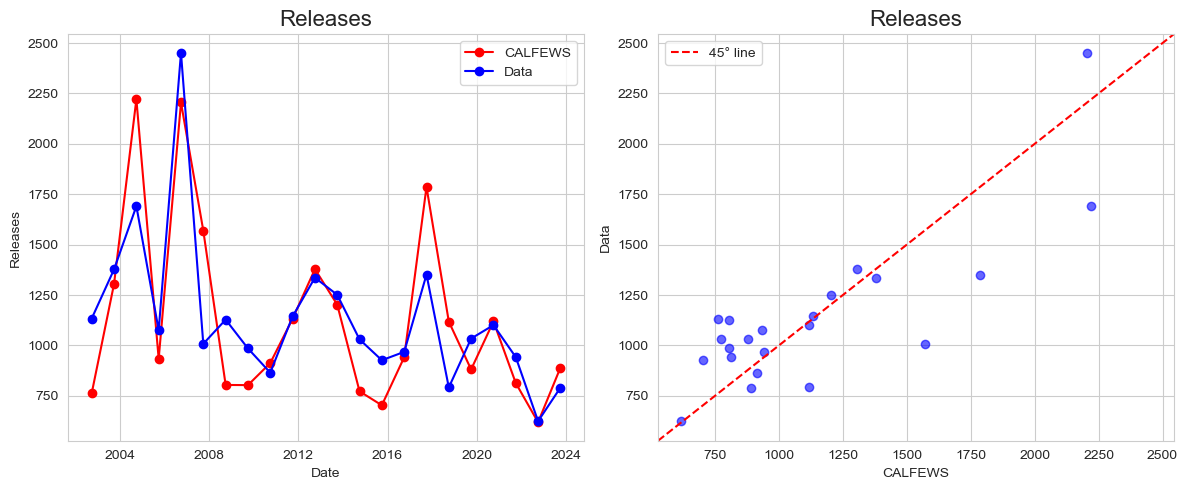

In [17]:
#Total Releases from Trinity
compare_series(datDaily['trinity_R'].resample('A-SEP').sum(), cfs_tafd*input_data['TRT_otf'].resample('A-SEP').sum(),"10-01-2001", "09-30-2023","Releases")

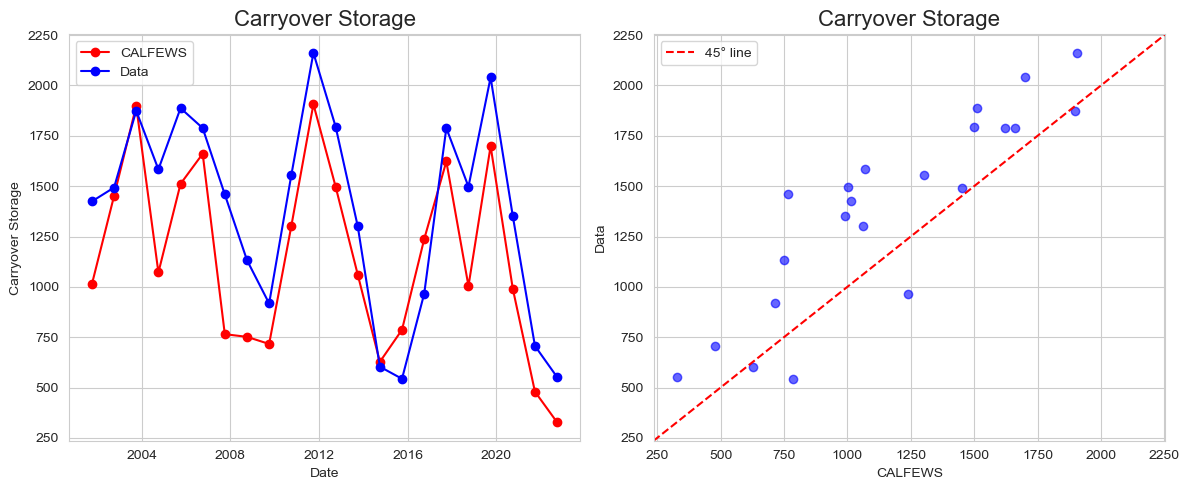

In [18]:
compare_series(datDaily['trinity_S'][datDaily.index.strftime('%m-%d') == '10-01'],
               0.001*input_data['TRT_storage'][input_data.index.strftime('%m-%d') == '10-01'],
               "10-01-2001", "09-30-2023","Carryover Storage")

In [19]:
#Read the lewiston reports 
lewiston = pd.read_csv("WAPA_CVP_Manuscript_Analysis/USBR_Reports/data/Lewiston_Daily_Operations.csv", index_col=0)
lewiston.index = pd.DatetimeIndex(lewiston.index)
lewiston = lewiston[lewiston.index < pd.Timestamp('2023-10-01')]
cfs_to_tafd = 1.98211*10**-3
lewiston['Restoration'] = lewiston['Power'] + lewiston['Outlet'] + lewiston['Spill'] 
lewiston['Restoration'] = lewiston['Restoration']*cfs_to_tafd
lewiston['Diversion'] = lewiston['Diversion']*cfs_to_tafd

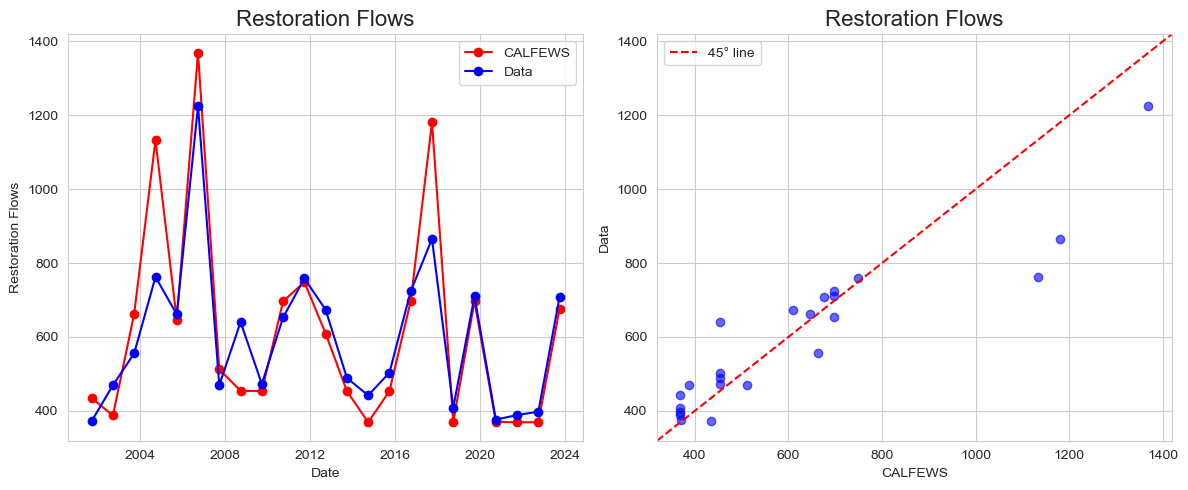

In [20]:
#Restoration Flows from Trinity
compare_series(datDaily['trinity_restoration'].resample('A-SEP').sum()[5:28], 
               lewiston['Restoration'].resample('A-SEP').sum(),
               "2001-09-30", "2023-10-01","Restoration Flows")

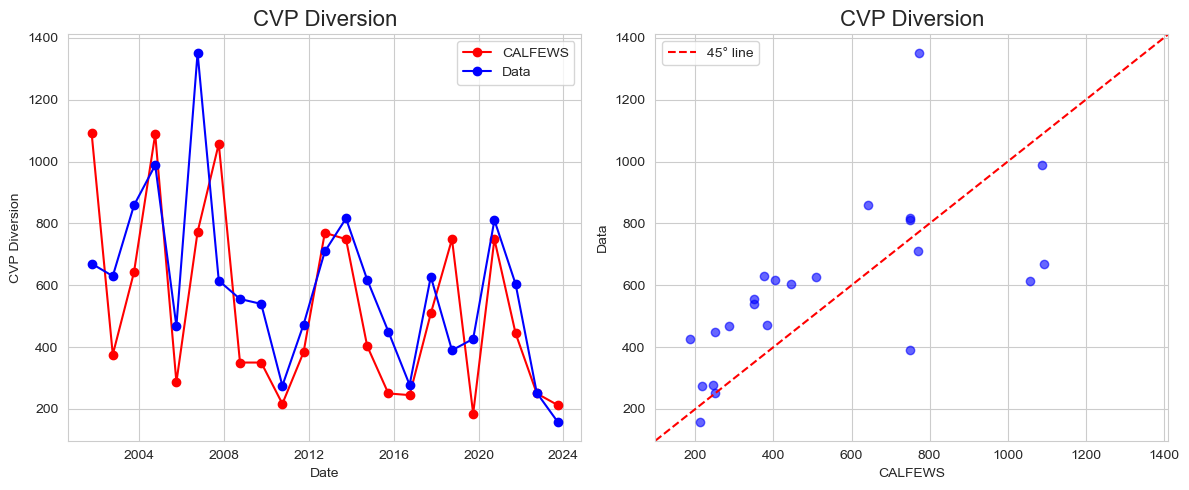

In [21]:
#Diversions from Trinity
compare_series(datDaily['trinity_diversions'].resample('A-SEP').sum()[5:28], 
               lewiston['Diversion'].resample('A-SEP').sum(),
               "2001-09-30", "2023-10-01","CVP Diversion")

Text(0, 0.5, 'Storage (TAF)')

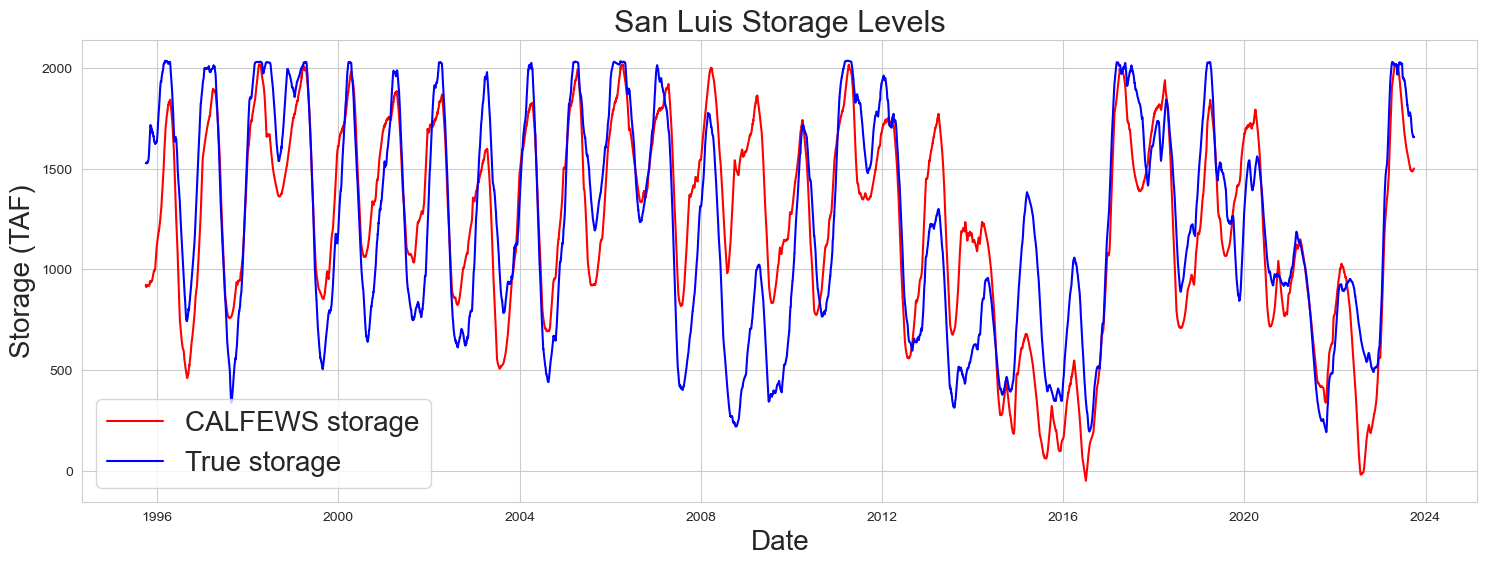

In [22]:
#Overall San Luis Storage
plt.figure(figsize=(18,6))
plt.plot(datDaily['sanluisstate_S']+datDaily['sanluisfederal_S'], linestyle='-', color = 'red', label='CALFEWS storage')
plt.plot(input_data['SL_storage']/1000, linestyle='-', color = 'blue', label='True storage')
plt.legend(fontsize = 20)
plt.title('San Luis Storage Levels', fontsize = 22)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Storage (TAF)', fontsize = 20)

Text(0, 0.5, 'Storage (TAF)')

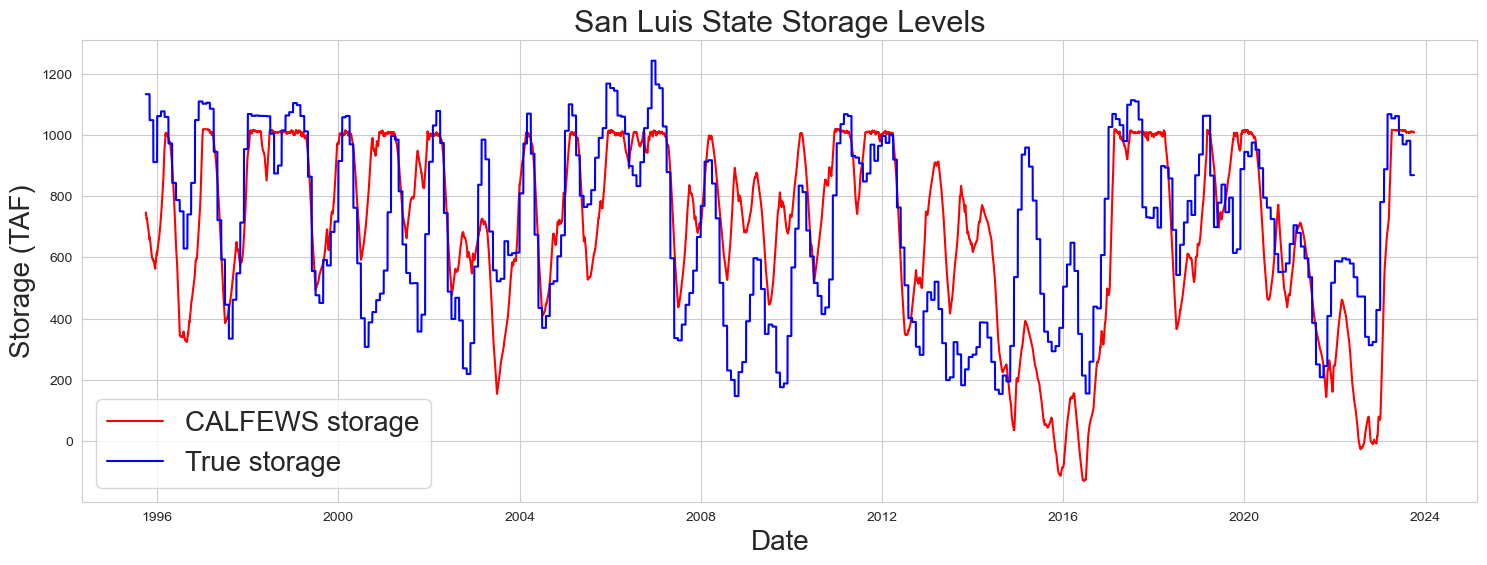

In [23]:
#San Luis State Storage
plt.figure(figsize=(18,6))
plt.plot(datDaily['sanluisstate_S'], linestyle='-', color = 'red', label='CALFEWS storage')
plt.plot(input_data['SLS_storage']/1000, linestyle='-', color = 'blue', label='True storage')
plt.legend(fontsize = 20)
plt.title('San Luis State Storage Levels', fontsize = 22)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Storage (TAF)', fontsize = 20)

Text(0, 0.5, 'Storage (TAF)')

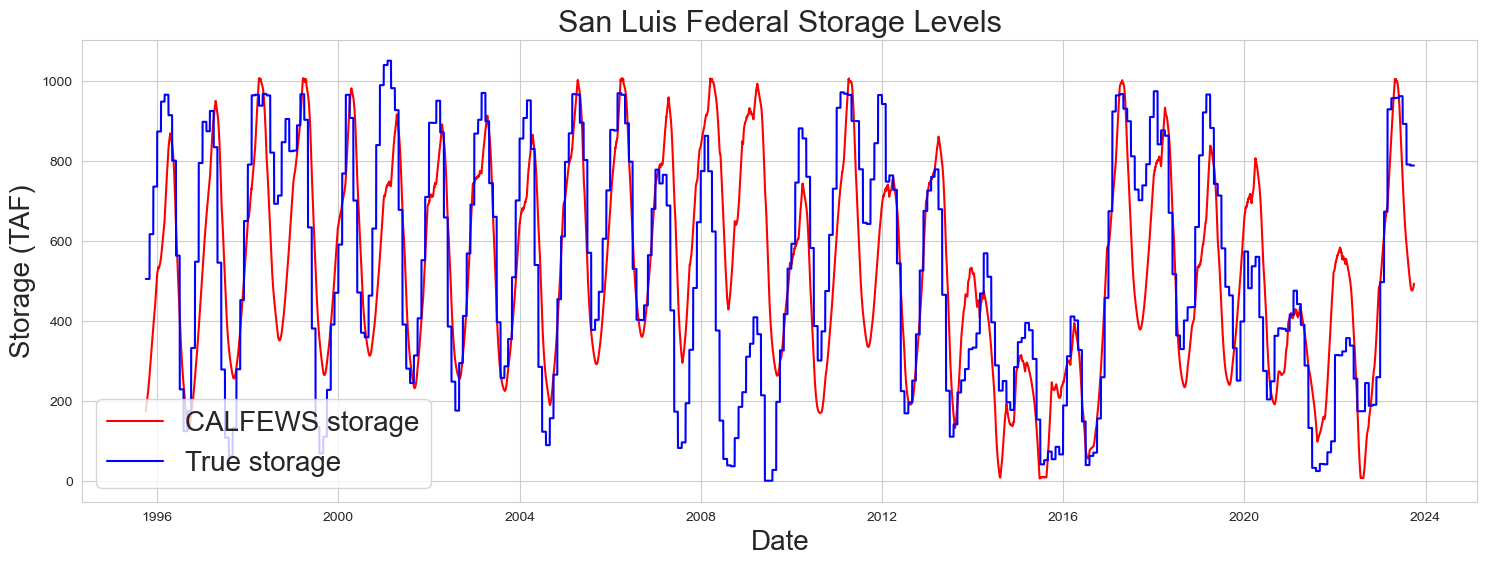

In [24]:
#San Luis Federal Storage
plt.figure(figsize=(18,6))
plt.plot(datDaily['sanluisfederal_S'], linestyle='-', color = 'red', label='CALFEWS storage')
plt.plot(input_data['SLF_storage']/1000, linestyle='-', color = 'blue', label='True storage')
plt.legend(fontsize = 20)
plt.title('San Luis Federal Storage Levels', fontsize = 22)
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Storage (TAF)', fontsize = 20)

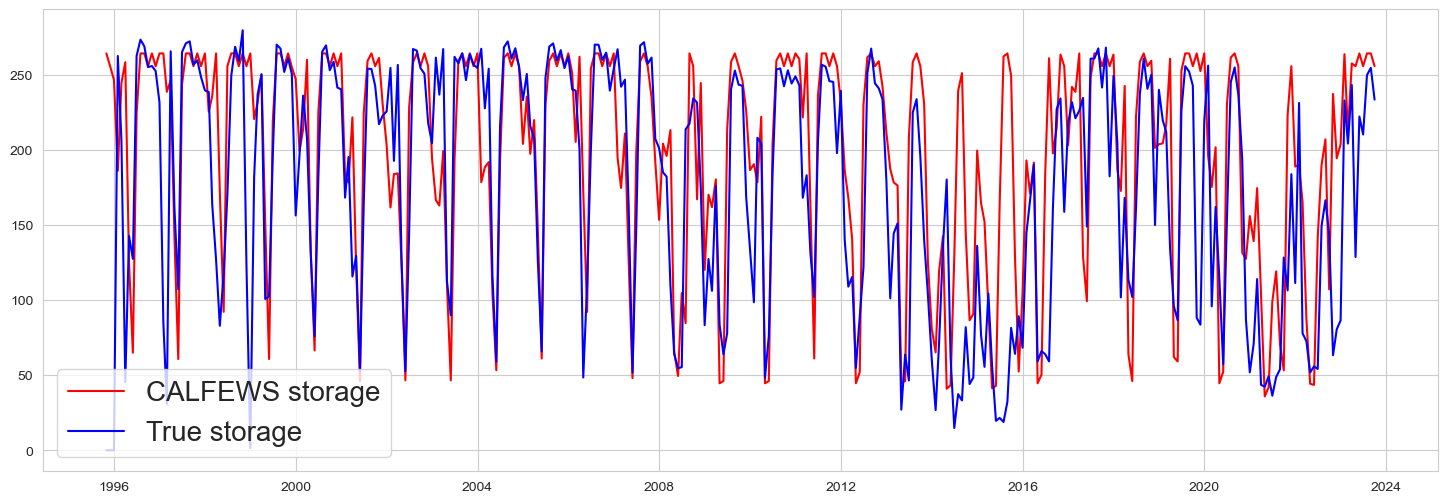

In [25]:
#Tracy Pumping
plt.figure(figsize=(18,6))
plt.plot(datDaily['delta_TRP_pump'].resample('M').sum(), linestyle='-', color = 'red', label='CALFEWS storage')
plt.plot(cfs_tafd*input_data['TRP_pump'].resample('M').sum(), linestyle='-', color = 'blue', label='True storage')
plt.legend(fontsize = 20)